# Grzegorz Krochmal and Katarzyna Kryńska
## *Predicting house prices*

# Introduction

In our research we will try to predict the final price of house based on numerous explanatory variables that are both numerical and categorical. We will use three regression methods (linear regression, ridge regression and lasso regression) and compare their accuracy.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_selection import VarianceThreshold, f_regression
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold
import collections
%matplotlib inline
from yellowbrick.regressor import ResidualsPlot
import sklearn.metrics as metrics

# 1. Data Overview

Our dataset comes from a popular kaggle competition (4,759 teams and counting)[<sup>1</sup>](#fn1). The dataset consists of 79 explanatory variables that describe aspects of residential homes in Ames, Iowa.
<span id="fn1"> https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview/description</span>

In [2]:
# Import data
data = pd.read_csv("train.csv")

At first we have a brief look at the initial form of our data, so to get sense how we should prepare our data to make it suitable for the modelling


In [3]:
data.head(20)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


Number of rows is:

In [4]:
data.shape[0]

1460

Types of variables in dataset, it is really long so we will only show the number of variables in specific group:

In [5]:
data.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

Now we know that our data has 81 columns and 1460 rows. The number of columns is definetely too big for the purpose of this analysis. So our first task will be to select the limited number of features which will suit our model in the best way.

# 2. Data preparation

## 2.1. Dependent variable SalePrice overview

Our dependent variable is SalePrice, which is the price the house were sold. Here are some basic information about it 

In [6]:
data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

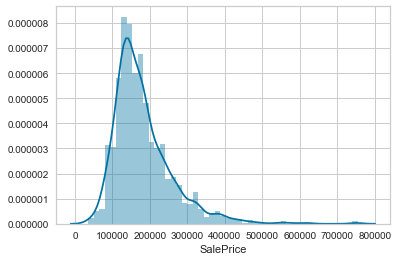

In [7]:
sns.distplot(data["SalePrice"])

In [8]:
print("The skewness is:",data.SalePrice.skew())
print("The kurtosis is:",data.SalePrice.kurt())

The skewness is: 1.8828757597682129
The kurtosis is: 6.536281860064529


So we can see that our dependent variable does not have a perfect normal distribution. We can try improving it by log normalization 


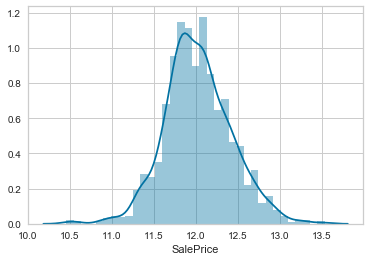

In [9]:
sns.distplot(np.log1p(data.SalePrice))

We can see that actually the log normalized distribution of dependent variable seems to be closer to the normal distribution. We will not modify SalesPrice variable now. But just in case we will save the log normalized one in memory

In [10]:
log1SalePrice = np.log1p(data.SalePrice)

## 2.2. Clearing the dataset of redundant variables and dealing with missing data

### 2.2.1. Dropping redundant variables (numerical)

To avoid Multicollinearity in our models, we will try to distinguish independent variables that have high pairwise correlations and remove them from our model.
Before we do that, we will get rid of Id variable which is surely not going to be an explanatory variable in our model. 

In [11]:
data = data.drop(columns = "Id")

Now we can take a look at the correlation matrix for continous variables.

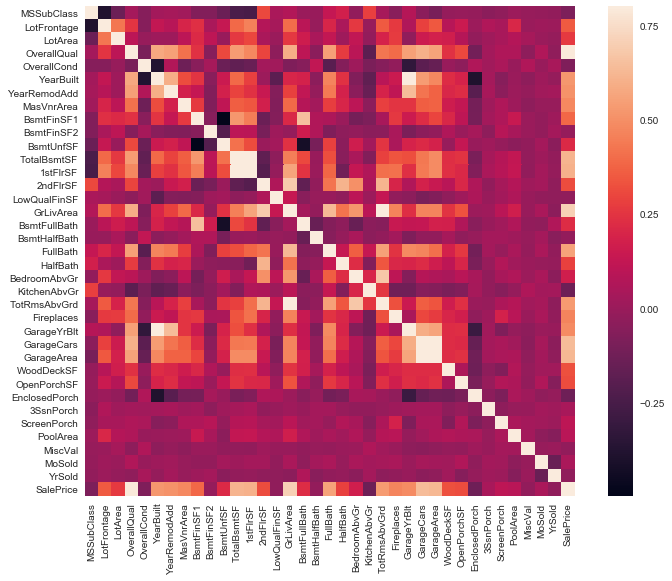

In [12]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

There is a high correlation between variables GarageArea/GarageCars and 1stFlrSF/TotalBsmtSF. 
1. First let's take a look at Garage variables. It is pretty obvious GarageCars which is "Size of garage in car capacity" is correlated with the area of garage. Therefore there is no need to keep both variables 
2. The second relation is between the total square feet of First floor and total square feet of basement. It's again pretty self explanatory that those variables are correlated. 
3. There is also a high correlation between YearBuilt and GarageYrBlt - most of the garages were built at the same time as the original construction. 

Therefore, we will dispose variables GarageCars, TotalBsmtSF and GarageYrBlt.

In [13]:
data = data.drop(columns = ["GarageCars", "TotalBsmtSF", "GarageYrBlt"])

### 2.2.2. Dropping redundant variables (categorical)

Now we will look for association between categorical data. In order to do that, firstly we will deal with NaN values. We will put "NA" value into such columns for which NaN value does not mean missing data, eg. for "Pool quality" NaN means there is no pool and not missing data.

In [14]:
na_cols = ["Alley", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond", "PoolQC", "Fence", "MiscFeature"]
for nas in na_cols:
    if "Bsmt" in nas:
        data[nas] = data[nas].fillna("No basement")
    elif "Garage" in nas:
        data[nas] = data[nas].fillna("No garage")
    else:
        data[nas] = data[nas].fillna("No {}".format(nas))

categorical_df = data.select_dtypes(include='object')
col_names = categorical_df.columns.values.tolist()

Now we can assume that other NaN values in the dataset are missing data.

In [15]:
na_percantage = dict((data.isna().sum()/data.shape[0])*100)
na_percantage 
na_percentage_sorted = sorted(na_percantage.items(), key=lambda kv: kv[1], reverse=True)
na_percentage_sorted = collections.OrderedDict(na_percentage_sorted)
for key,val in na_percentage_sorted.items():
    if val>0:
        print(key, ": ", val, "%", sep="")

LotFrontage: 17.73972602739726%
MasVnrType: 0.547945205479452%
MasVnrArea: 0.547945205479452%
Electrical: 0.0684931506849315%


As we can see now there are few variables which contain NA values. It's mostly the problem in case of variable LotFrontage which has over 17% of missing data. LotFrontage is a variable containing information about linear feet of street connected to property. We believe that this variable is not really important so we allowed ourselves to drop it. 

In [16]:
data = data.drop(columns='LotFrontage')
data[pd.isnull(data).any(axis=1)]

,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
234,60,RL,7851,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,5,2010,WD,Normal,216500
529,20,RL,32668,Pave,No Alley,IR1,Lvl,AllPub,CulDSac,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,3,2007,WD,Alloca,200624
650,60,FV,8125,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,5,2008,WD,Normal,205950
936,20,RL,10083,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,8,2009,WD,Normal,184900
973,20,FV,11639,Pave,No Alley,Reg,Lvl,AllPub,Corner,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,12,2008,New,Partial,182000
977,120,FV,4274,Pave,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,11,2007,New,Partial,199900
1243,20,RL,13891,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,9,2006,New,Partial,465000
1278,60,RL,9473,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,3,2008,WD,Normal,237000
1379,80,RL,9735,Pave,No Alley,Reg,Lvl,AllPub,Inside,Gtl,...,0,No PoolQC,No Fence,No MiscFeature,0,5,2008,WD,Normal,167500


This leaves us with 9 rows with missing values - where missing variables are either categorical (MasVnrType and Electrical) or numerical (MasVnrArea). To avoid dropping rows, we will impute missing values in our dataset. For non-ordinal data we will use mode, while for numerical data we will use average.

In [17]:
data.loc[data.MasVnrType.isna(), "MasVnrType"] = data["MasVnrType"].mode()[0]
data.loc[data.Electrical.isna(), "Electrical"] = data["Electrical"].mode()[0]
data.loc[data.MasVnrArea.isna(), "MasVnrArea"] = data["MasVnrArea"].mean()

After that, we can calculate Cramer's V matrix, which contains measure of association between categorical features. Cramer's V is similar to correlation as the output is in the range of [0,1], where 0 indicates no association and 1 full association. Naturally, Cramer's V matrix is symmetrical.

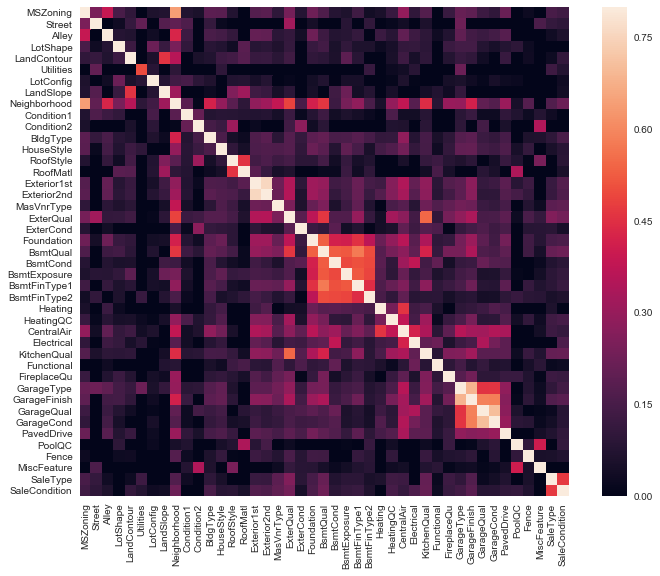

In [18]:
# source for cramers_v function in python:
# https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

corrmat = pd.DataFrame(0, index=col_names, columns=col_names).astype('float64')

for i, column_i in enumerate(categorical_df):
    for j, column_j in enumerate(categorical_df):
        corrmat.iloc[i][column_j] = cramers_v(categorical_df[column_i], categorical_df[column_j])

f, ax = plt.subplots(figsize=(12, 9))    
sns.heatmap(corrmat, vmax=.8, square=True);

Again, we can extract a few variables that seem to be strongly associated. 
1. Exterior1st and Exterior2nd - both variables concern one feature, so we decided to leave just one in our analysis.
2. GarageQual and GarageCond - rather unsurprisingly, garage quality corresponds with garage condition. Therefore we decided to omit GarageCond.
3. GarageType and GarageFinish - interior finish of the garage seems to be correlated with garage location. Thus, we will only usue GarageType.

In [19]:
data = data.drop(columns = ["Exterior2nd", "GarageCond", "GarageFinish"])

## 2.3. One hot encoding


We have already dealt with some issues which were present in our dataset, removing NAs and some highly correlated variables. The next step is to introduce a proper approach to work with categorogical variables which are higly represented in our case. We decided to use One Hot Encoding to solve this

In [20]:
nominal_variables = []
num_variables = []
for i in data.columns:
    if str(data[i].dtypes) == "object":
        nominal_variables.append(i)
        print(i,":", data[i].unique(), ";" ,len(data[i].unique()))
    else:
        num_variables.append(i)
data = pd.concat([data[num_variables], pd.get_dummies(data[nominal_variables])], axis=1)

MSZoning : ['RL' 'RM' 'C (all)' 'FV' 'RH'] ; 5
Street : ['Pave' 'Grvl'] ; 2
Alley : ['No Alley' 'Grvl' 'Pave'] ; 3
LotShape : ['Reg' 'IR1' 'IR2' 'IR3'] ; 4
LandContour : ['Lvl' 'Bnk' 'Low' 'HLS'] ; 4
Utilities : ['AllPub' 'NoSeWa'] ; 2
LotConfig : ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3'] ; 5
LandSlope : ['Gtl' 'Mod' 'Sev'] ; 3
Neighborhood : ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste'] ; 25
Condition1 : ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe'] ; 9
Condition2 : ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosN' 'PosA' 'RRAn' 'RRAe'] ; 8
BldgType : ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs'] ; 5
HouseStyle : ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin'] ; 8
RoofStyle : ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed'] ; 6
RoofMatl : ['CompShg' 'WdSh

# 3. Linear Regression

## 3.1. Feature Selection

After all the operations conducted above we were left with 272 independent features. That put as in a position to use a technique to cut down this number to simplify analysis. We decided to use Forward Feature Selection Method (from specific to general). This means we will add independent variables to our model step by step - firstly we will estimate simple regressions with just one variable for all variables and will choose the variable that is most significant. Then we will estimate regressions with two variables and will again choose the most significant variable and add it to the model. We will continue to do so until no of other variables added to the model will be significant, where are acceptable p-value is set at 0.05. The code which is the implementation of that is presented below.

In [21]:
X = data.loc[:, data.columns != 'SalePrice'] 
y = data.SalePrice

In [22]:
final = {}
Xx = X.copy()
i = 0
f = 0
while f != 1:
    working_dict = {}
    
    features = list(Xx.columns)
    for feature in features:
        
        names = list(final.keys())
        names.append(feature)

        X2 = sm.add_constant(X.loc[:, names])
        est = sm.OLS(y, X2)

        results = est.fit()
        temp = dict(results.pvalues)
        
        for k, v in temp.items():
            if k in final:
                pass
            else:
                working_dict[k] = v
        working_dict.pop("const")
    
    sorted_x = sorted(working_dict.items(), key=lambda kv: kv[1]) 
    
    if sorted_x[0][1] <= 0.05:
        final[sorted_x[0][0]] = sorted_x[0][1]
        Xx.drop(labels = sorted_x[0][0], axis = 1, inplace = True)
        i += 1
    else:
        f += 1

The Forward Feature Selection Method gave us 57 independent variables. Now we can limit our dataset to them + the dependent variable. 

In [23]:
data1 = data[["SalePrice"] + list(final.keys())]

In [24]:
data1.describe()

,SalePrice,OverallQual,GrLivArea,BsmtQual_Ex,BsmtFinSF1,RoofMatl_ClyTile,YearBuilt,MSSubClass,Condition2_PosN,KitchenQual_Ex,...,GarageType_No garage,GarageQual_No garage,ScreenPorch,WoodDeckSF,FireplaceQu_No FireplaceQu,GarageQual_Ex,Fence_GdPrv,BsmtFinType1_GLQ,Condition1_RRAe,Condition2_PosA
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,0.082877,443.639726,0.000685,1971.267808,56.897260,0.001370,0.068493,...,0.055479,0.055479,15.060959,94.244521,0.472603,0.002055,0.040411,0.286301,0.007534,0.000685
std,79442.502883,1.382997,525.480383,0.275790,456.098091,0.026171,30.202904,42.300571,0.036999,0.252677,...,0.228992,0.228992,55.757415,125.338794,0.499420,0.045299,0.196989,0.452187,0.086502,0.026171
min,34900.000000,1.000000,334.000000,0.000000,0.000000,0.000000,1872.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,129975.000000,5.000000,1129.500000,0.000000,0.000000,0.000000,1954.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,163000.000000,6.000000,1464.000000,0.000000,383.500000,0.000000,1973.000000,50.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,214000.000000,7.000000,1776.750000,0.000000,712.250000,0.000000,2000.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,168.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,755000.000000,10.000000,5642.000000,1.000000,5644.000000,1.000000,2010.000000,190.000000,1.000000,1.000000,...,1.000000,1.000000,480.000000,857.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We realised that due to one hot encoding, two variables are now identical, ie. GarageType_No garage and GarageQual_No garage. Naturally, we do not need both of them, so we will exclude one.
We also spotted that there is a dummy variable, Condition2_PosA, that is equal to 1 just in one case. We will also remove this variables.

In [25]:
data1 = data1.drop(columns = ['GarageQual_No garage', 'Condition2_PosA'])

In [26]:
data1.describe()

,SalePrice,OverallQual,GrLivArea,BsmtQual_Ex,BsmtFinSF1,RoofMatl_ClyTile,YearBuilt,MSSubClass,Condition2_PosN,KitchenQual_Ex,...,Street_Grvl,LandSlope_Sev,GarageType_No garage,ScreenPorch,WoodDeckSF,FireplaceQu_No FireplaceQu,GarageQual_Ex,Fence_GdPrv,BsmtFinType1_GLQ,Condition1_RRAe
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,180921.195890,6.099315,1515.463699,0.082877,443.639726,0.000685,1971.267808,56.897260,0.001370,0.068493,...,0.004110,0.008904,0.055479,15.060959,94.244521,0.472603,0.002055,0.040411,0.286301,0.007534
std,79442.502883,1.382997,525.480383,0.275790,456.098091,0.026171,30.202904,42.300571,0.036999,0.252677,...,0.063996,0.093973,0.228992,55.757415,125.338794,0.499420,0.045299,0.196989,0.452187,0.086502
min,34900.000000,1.000000,334.000000,0.000000,0.000000,0.000000,1872.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,129975.000000,5.000000,1129.500000,0.000000,0.000000,0.000000,1954.000000,20.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,163000.000000,6.000000,1464.000000,0.000000,383.500000,0.000000,1973.000000,50.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,214000.000000,7.000000,1776.750000,0.000000,712.250000,0.000000,2000.000000,70.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,168.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,755000.000000,10.000000,5642.000000,1.000000,5644.000000,1.000000,2010.000000,190.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,480.000000,857.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3.2. Linear Regression

Firstly, we will split our dataset into test and training sets. We will do the same split for later regressions so that we can compare the accuracy of each model on test set.

In [27]:
X_lm = data1.loc[:, data1.columns != 'SalePrice'] 
y_lm = data1.SalePrice

X_lm_train, X_lm_test, y_lm_train, y_lm_test = train_test_split(X_lm, y_lm, test_size=0.3, random_state=42)

Having done that, we will move over to estimating the model.

In [28]:
mod = sm.OLS(y_lm_train, X_lm_train)
res_final = mod.fit()
res_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                     204.7
Date:                Tue, 28 May 2019   Prob (F-statistic):               0.00
Time:                        23:57:46   Log-Likelihood:                -11669.
No. Observations:                1022   AIC:                         2.345e+04
Df Residuals:                     967   BIC:                         2.372e+04
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
OverallQual                 7817.3442   1019.854      7.665      0.000    5815.962    9818.726
GrLivArea                     52.6437      3.594     14.649      0.000      45.591      59.696
BsmtQual_Ex                 2.436e+04   3631.892      6.708      0.000    1.72e+04    3.15e+04
BsmtFinSF1                    23.2668      2.961      7.858      0.000      17.456      29.077
RoofMatl_ClyTile           -6.658e+05   3.67e+04    -18.151      0.000   -7.38e+05   -5.94e+05
YearBuilt                    389.2879     44.764      8.696      0.000     301.442     477.134
MSSubClass                  -183.6354     23.580     -7.788      0.000    -229.910    -137.361
Condition2_PosN            -2.172e+05   1.75e+04    -12.380      0.000   -2.52e+05   -1.83e+05
KitchenQual_Ex               2.24e+04   4047.256      5.534      0.000    1.45e+04    3.03e+04
BsmtExposure_Gd             2.275e+04   2866.442      7.936      0.000    1.71e+04    2.84e+04
OverallCond                 4619.7752    830.446      5.563      0.000    2990.092    6249.458
SaleType_New                1.897e+04   4007.612      4.733      0.000    1.11e+04    2.68e+04
Neighborhood_NoRidge        3.876e+04   5160.498      7.511      0.000    2.86e+04    4.89e+04
LotArea                        0.4284      0.098      4.378      0.000       0.236       0.620
BedroomAbvGr               -4125.1241   1418.439     -2.908      0.004   -6908.698   -1341.550
Neighborhood_NridgHt        2.414e+04   4233.390      5.703      0.000    1.58e+04    3.25e+04
Neighborhood_StoneBr         4.35e+04   5727.923      7.595      0.000    3.23e+04    5.47e+04
Neighborhood_Crawfor        2.463e+04   4105.137      6.000      0.000    1.66e+04    3.27e+04
GarageArea                    31.8960      5.646      5.649      0.000      20.816      42.976
RoofMatl_WdShngl            4.118e+04   1.26e+04      3.258      0.001    1.64e+04     6.6e+04
ExterQual_Ex                2.326e+04   5274.295      4.411      0.000    1.29e+04    3.36e+04
Functional_Typ              1.521e+04   2968.471      5.124      0.000    9385.289     2.1e+04
PoolQC_Ex                   1.169e+05   1.77e+04      6.602      0.000    8.21e+04    1.52e+05
SaleCondition_Normal        5422.2060   2597.297      2.088      0.037     325.218    1.05e+04
Neighborhood_Somerst        1.409e+04   3619.669      3.893      0.000    6987.381    2.12e+04
Condition1_Norm             8029.4588   2253.639      3.563      0.000    3606.873    1.25e+04
Exterior1st_BrkFace          2.14e+04   4219.343      5.072      0.000    1.31e+04    2.97e+04
BsmtExposure_Av             6209.7345   2245.093      2.766      0.006    1803.919    1.06e+04
HeatingQC_Ex                4965.0807   1820.728      2.727      0.007    1392.047    8538.114
Neighborhood_BrkSide        1.432e+04   385

The R-squared statistic tells that our model explains 92% of variability. It might indicate that our model is well fitted or overfitted, so we will test on test data how good it actually predicts house prices.

Before we move on to that, we will check the distribution of errors.

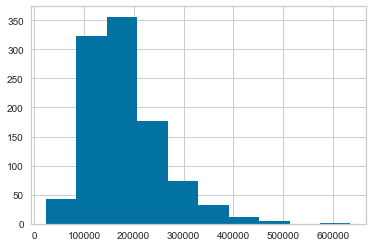

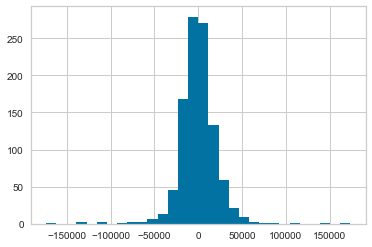

In [29]:
plt.hist(res_final.predict())
plt.show()
plt.hist(res_final.predict() - y_lm_train.values, bins=30)
plt.show()

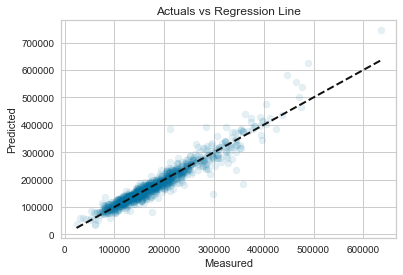

In [31]:
preds = res_final.predict()
fig,ax = plt.subplots()
ax.scatter(preds,  y_lm_train.values, alpha=0.1)
ax.plot([preds.min(), preds.max()], [preds.min(), preds.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Actuals vs Regression Line")
fig.show()

The histogram suggests that the distribution of erros is normal, which indicated that our model is correctly specified.
Scatterplot shows that our model seems to generate decent predictions for out dataset.

Now we will check the R-squared statistic and some error measures for the train dataset.

In [32]:
preds = res_final.predict()
print("R^2: %.2f" % metrics.r2_score(y_lm_train.values, preds))
print("Mean squared error: %.2f" % metrics.mean_squared_error(y_lm_train.values, preds))
print("Mean absolute error: %.2f" % metrics.mean_absolute_error(y_lm_train.values, preds))

R^2: 0.92
Mean squared error: 484065350.82
Mean absolute error: 14539.54


The R-squared statistic is pretty high and mean absolute error does not seem to be too big, taking into consideration that the mean value of house price was 180,921. 

However, we would like to check if our model gives stable, good results. In order to do that, we will use KFold Cross validation. We will split our data into test and train subsets 10 times and calculate R-squared statistic, MSE and MAE for each of them.

In [33]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)

R2_train = list()
R2_test = list()
MSE_train = list()
MSE_test = list()
MAE_train = list()
MAE_test = list()

i = 0
for train, test in kf.split(X_lm_train.index.values):
    mod = sm.OLS(y_lm_train.iloc[train], X_lm_train.iloc[train])
    res = mod.fit()
    preds_train = res.predict()
    preds_test = res.predict(X_lm_train.iloc[test])
    R2_train.append(metrics.r2_score(y_lm_train.iloc[train].values, preds_train))
    R2_test.append(metrics.r2_score(y_lm_train.iloc[test].values, preds_test))
    MSE_train.append(metrics.mean_squared_error(y_lm_train.iloc[train].values, preds_train))
    MSE_test.append(metrics.mean_squared_error(y_lm_train.iloc[test].values, preds_test))
    MAE_train.append(metrics.mean_absolute_error(y_lm_train.iloc[train].values, preds_train))
    MAE_test.append(metrics.mean_absolute_error(y_lm_train.iloc[test].values, preds_test))
    i += 1
    
pd.DataFrame(list(zip(R2_train,R2_test,MSE_train,MSE_test,MAE_train,MAE_test)), columns=['R2_train','R2_test', 'MSE_train', 'MSE_test', 'MAE_train', 'MAE_test'])

,R2_train,R2_test,MSE_train,MSE_test,MAE_train,MAE_test
0,0.922593,0.892900,4.507566e+08,8.285243e+08,14130.721480,18760.835936
1,0.917996,0.932999,5.059010e+08,3.084042e+08,14714.579546,13667.806053
2,0.922002,0.827001,4.947924e+08,5.227671e+08,14558.116173,15836.260437
3,0.918729,0.608118,5.026712e+08,1.744160e+09,14666.069784,17916.032024
4,0.923908,0.870617,4.536278e+08,8.451770e+08,14327.857117,17843.526482
5,0.917129,0.101393,5.062343e+08,4.665603e+09,14860.737296,19561.699623
6,0.918519,0.925517,4.990402e+08,3.759231e+08,14716.414369,14167.045703
7,0.929015,0.682162,4.285721e+08,1.858603e+09,14271.456198,19212.222485
8,0.928718,0.767600,3.892599e+08,2.516042e+09,13774.165011,20959.557311
9,0.923293,0.832385,4.575187e+08,1.067931e+09,14161.081828,17441.399695


The results seem to be pretty stable except for one case (6th evaluation), where our model explained only 10% of variability for the test subset and the Mean Squared Error is significantly higher.

A possible explanation for that is that 6th data split was just unfortunate for our model. Let's not forget that test subset in K-fold holds only 0.07% of all observations (70% of original dataset * 10% cut in K-Fold). Therefore, we can assume that our model gives pretty reliable estimation of house prices.

Finally, we will see the R-squared statistic and error measures on the test subset.

In [34]:
preds_test = res_final.predict(X_lm_test)
R2_ols = metrics.r2_score(y_lm_test.values, preds_test)
MSE_ols = metrics.mean_squared_error(y_lm_test.values, preds_test)
MAE_ols = metrics.mean_absolute_error(y_lm_test.values, preds_test)
print("R^2: %.2f" % R2_ols)
print("Mean squared error: %.2f" % MSE_ols)
print("Mean absolute error: %.2f" % MAE_ols)

R^2: 0.92
Mean squared error: 556553549.62
Mean absolute error: 15144.66


R-squared for the test subset is just as high as it was for the train subset, while the errors are a bit bigger, but it still seems like a good fit. 

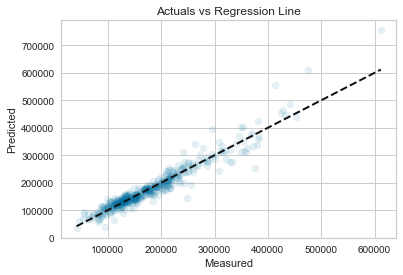

In [35]:
fig,ax = plt.subplots()
ax.scatter(preds_test,  y_lm_test.values, alpha=0.1)
ax.plot([preds_test.min(), preds_test.max()], [preds_test.min(), preds_test.max()], 'k--', lw=2)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Actuals vs Regression Line")
fig.show()

# 4. Lasso Regression

The alternative way than Linear Regression to handle our regression task is to use Lasso Regression. This method doesn't need feature selection before modelling because it deals with this issue with by itself using L1 regularization. We will start from splitting our dataset into test and training groups and then perform kfold cross validation with Lasso Regression

## 4.1. Creating Test and Training sets

In [36]:
X_lasso = data.loc[:, data.columns != 'SalePrice'] 
y_lasso = data.SalePrice

X_lasso_train, X_lasso_test, y_lasso_train, y_lasso_test = train_test_split(X_lasso, y_lasso, test_size=0.3, random_state=42)

## 4.2. Kfold Cross Validation with Lasso Regression

Now we will conduct our modelling. We have to specify the vector of different  "alphas" which will be used in Lasso Regression to find the best one (the higher the alpha the more feature coefficients are 0)  

In [37]:
# inspiration: https://towardsdatascience.com/how-to-perform-lasso-and-ridge-regression-in-python-3b3b75541ad8
lasso = Lasso()
params = {"alpha": [1e-15, 1e-10, 1e-8, 1e-4,1e-2,1, 2, 5, 10,20, 40, 50, 100, 1000]}
lasso_regression = GridSearchCV(lasso, params, scoring = 'neg_mean_squared_error')
lasso_regression.fit(X_lasso_train, y_lasso_train)

C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.01, 1, 2, 5,
                                   10, 20, 40, 50, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [38]:
print("best Neg_MSE: ", lasso_regression.best_score_,"\nbest params: ", lasso_regression.best_params_)

best Neg_MSE:  -1289438420.172529 
best params:  {'alpha': 1}


In [39]:
y_lasso_predict = lasso_regression.predict(X_lasso_test)

## 4.3. Model Evaluation

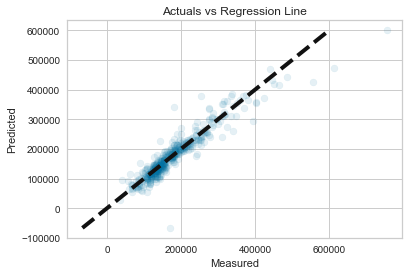

In [40]:
fig,ax = plt.subplots()
ax.scatter(y_lasso_test, y_lasso_predict, alpha=0.1)
ax.plot([y_lasso_predict.min(), y_lasso_predict.max()], [y_lasso_predict.min(), y_lasso_predict.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Actuals vs Regression Line")
fig.show()

The regression line seems to be well matched with actual values 

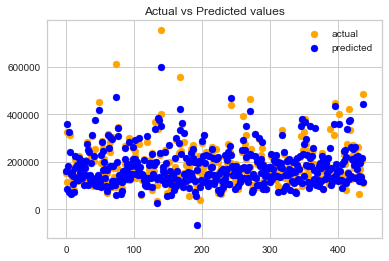

In [41]:
plt.scatter(*zip(*list(enumerate(y_lasso_test))), c = "orange")
plt.scatter(*zip(*list(enumerate(y_lasso_predict))), c= "blue")
plt.gca().legend(('actual',"predicted"))
plt.title("Actual vs Predicted values")
fig.show()

Here we can see that predicted values in most cases coincide with actual values

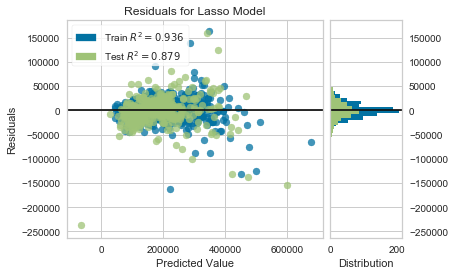

In [42]:
visualizer = ResidualsPlot(lasso)
visualizer.fit(X_lasso_train, y_lasso_train)
visualizer.score(X_lasso_test, y_lasso_test)  
visualizer.poof() 

The plot of residuals shows us that our model gives us pretty acceptable predictions. The residuals are randomly spread and in most cases its value is close to 0. At the histogram we can see that our error is normally distributed around 0. 

# 5. Ridge Regression

The alternative way to L1 regularization used in Lasso Regression is L2 regularization which we can apply with Ridge Regression. The code is really similar to this from Lasso Regression

## 5.1. Creating Test and Training sets

In [43]:
X_ridge = data.loc[:, data.columns != 'SalePrice'] 
y_ridge = data.SalePrice

X_ridge_train, X_ridge_test, y_ridge_train, y_ridge_test = train_test_split(X_ridge, y_ridge, test_size=0.3, random_state=42)

## 5.2. Kfold Cross Validation with Ridge Regression

In [44]:
ridge = Ridge()
params = {"alpha": [1e-15, 1e-10, 1e-8, 1e-4,1e-2,1, 2, 5, 10,20, 40, 50, 100, 1000]}
ridge_regression = GridSearchCV(ridge, params, scoring = 'neg_mean_squared_error')
ridge_regression.fit(X_lasso_train, y_lasso_train)

C:\Users\xx\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.01, 1, 2, 5,
                                   10, 20, 40, 50, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [45]:
print("best Neg_MSE: ", ridge_regression.best_score_,"\nbest params: ", ridge_regression.best_params_)

best Neg_MSE:  -1306461953.6928668 
best params:  {'alpha': 10}


We can see that the negative MSE is lower than in the case of Lasso Regression. However we can still check how the model performs 

In [46]:
y_ridge_predict = ridge_regression.predict(X_ridge_test)

## 5.3. Model Evaluation

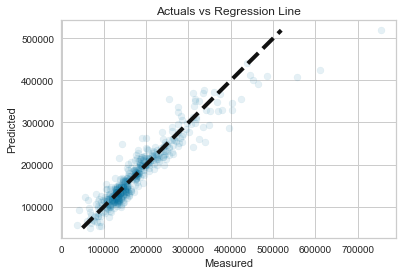

In [47]:
fig,ax = plt.subplots()
ax.scatter(y_ridge_test, y_ridge_predict, alpha=0.1)
ax.plot([y_ridge_predict.min(), y_ridge_predict.max()], [y_ridge_predict.min(), y_ridge_predict.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.title("Actuals vs Regression Line")
fig.show()

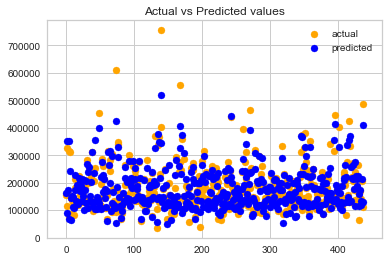

In [48]:
plt.scatter(*zip(*list(enumerate(y_ridge_test))), c = "orange")
plt.scatter(*zip(*list(enumerate(y_ridge_predict))), c= "blue")
plt.gca().legend(('actual',"predicted"))
plt.title("Actual vs Predicted values")
fig.show()

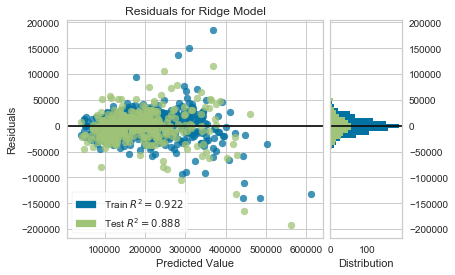

In [49]:
visualizer = ResidualsPlot(ridge)
visualizer.fit(X_ridge_train, y_ridge_train)
visualizer.score(X_ridge_test, y_ridge_test)  
visualizer.poof() 

Again, just like in case of Lasso Regression the prediction went pretty well. The residuals are in most rather randomly spread around the horizontal axis. They are in most cases concentrated around zero so it is also a good information. From the histogram we can also see that the error we obtained is normally distributed around zero. 

# 6. Models Comparison

To compare models to each other, we will calculate R-squared statistic eror measures (MAE and MSE), using package metrics.  

In [50]:
R2_lasso = metrics.r2_score(y_lasso_test.values, y_lasso_predict)
MSE_lasso = metrics.mean_squared_error(y_lasso_test.values, y_lasso_predict)
MAE_lasso = metrics.mean_absolute_error(y_lasso_test.values, y_lasso_predict)

R2_Ridge = metrics.r2_score(y_ridge_test.values, y_ridge_predict)
MSE_Ridge = metrics.mean_squared_error(y_ridge_test.values, y_ridge_predict)
MAE_Ridge = metrics.mean_absolute_error(y_ridge_test.values, y_ridge_predict)

print("R^2 OLS: %.2f" % R2_ols)
print("R^2 lasso: %.2f" % R2_lasso)
print("R^2 Ridge: %.2f" % R2_Ridge)
print("")
print("Mean squared error OLS: %.2f" % MSE_ols)
print("Mean squared error lasso: %.2f" % MSE_lasso)
print("Mean squared error Ridge: %.2f" % MSE_Ridge)
print("")
print("Mean absolute error OLS: %.2f" % MAE_ols)
print("Mean absolute error lasso: %.2f" % MAE_lasso)
print("Mean absolute error Ridge: %.2f" % MAE_lasso)

R^2 OLS: 0.92
R^2 lasso: 0.88
R^2 Ridge: 0.88

Mean squared error OLS: 556553549.62
Mean squared error lasso: 846234423.30
Mean squared error Ridge: 851234868.46

Mean absolute error OLS: 15144.66
Mean absolute error lasso: 17992.27
Mean absolute error Ridge: 17992.27


All statistics suggest that the model that fit our data best is the linear regression. That of course can be surprising, as lasso and ridge regressions are rather more sophisticated. However, it can be just a case of data specification that lead us to these conclusions.

# Summary

We tried to predict the final price of house based on many explanatory variables, using three machine learning methods - linear regression, ridge regression and lasso regression. All of these models showed good fit to the data. We discovered that for our dataset the most accurate model is linear regression.